# **MONTE CARLO METHODS AND FINITE-SIZE ANALYSIS IN PARAMAGNETIC-FERROMAGNETIC MODELS OF PHASE TRANSITION**

Authors:
* Carlo Divari
* Gloria Isotton
* Maryam Feizi
* Sara Munafò

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

from numba import jit, prange
from scipy.optimize import curve_fit

# **README** <ep>
The purpose of this work is to present a numerical study of the second-order phase transition in the 2D Ising model. We focused in particular on the estimation of the critical exponents, by using computational methods such that nonlinear fits and finite-size scaling techniques and we also evaluated the critical temperature. In doing so, Monte Carlo simulations are performed for different lattice sizes with periodic boundary conditions.
Energy, magnetization, specific heat, magnetic susceptibility and the correlation function are calculated and the critical exponents determined by finite-size scaling techniques.

# **INTRODUCTION**

In [2]:
#introduction

In [3]:
#ising

In [4]:
#metropolis 

In [5]:
#blablabla

# **SIMULATION OF A 2D ISING MODEL**

The system is generated as a L×L square lattice and in every site of the lattice a spin is set with equal probability of being ±1.  
We created one function to calculate the energy, one for the delta energy between two states and another one for the magnetization.

In [120]:
#Create a NxN lattice with random spin configuration
@jit(nopython=True)
def init_lattice(N):
    '''
    Return a random spin configuration in a 2d square lattice
    '''
    return np.random.choice(np.array([-1,1]),size=(N,N))

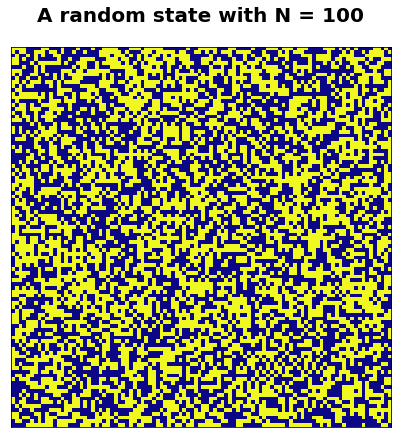

In [121]:
try_state = init_lattice(100)
fig, ax = plt.subplots(figsize=(9,7))
ax.matshow(try_state, cmap = plt.cm.plasma) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('A random state with N = 100', fontsize = 20, fontweight = "bold" )
plt.show()

In [122]:
#Let's define some useful functions
@jit(nopython=True)
def energy(state):
    
    '''define the energy at a given configuration'''
    
    N = state.shape[0]
    energy = 0
  
    for i in range(N):
        for j in range(N):

      # get nearest neighbours states
            nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
            energy +=  -state[i,j] * nn
    return energy / 2
    
@jit(nopython=True)    
def magnetization(state):
    
    '''define the magnetization per site'''
    
    Magn = np.sum(state)    
    return Magn

@jit(nopython=True)
def delta(s,a,b):
    L= int(s.shape[0])
    
    '''define delta E between 2 spin configurations'''

    return 2*s[a,b]*(s[a,(b+1)%L]+s[a,(b-1)%L]+s[(a+1)%L,b]+s[(a-1)%L,b])   #consider only nearest neighbours


## **METROPOLIS-HASTINGS ALGORITHM**

Metropolis algorithm was used for the Monte Carlo simulation of our system.
Choosing randomly one site (i,j) in the lattice, we computed the energy difference $∆E$ between the actual energy and the energy if the spin is flipped.
Then if $∆E < 0$,  the new configuration is accepted. If not, we accept it with probability $e^{−β∆E}$ where $β = \frac{1}{k_BT}$ and $k_B$ is the Boltzmann constant.
Energy and magnetization of the system are saved and then they are then averaged and observables calculated.

Before presenting the code, it is necessary to underline that in the function 'mc_step' we perform a single Monte Carlo step consisting of $L^2$ spin flip attempts while in the next function we simulate multiple times (namely 'realiz' times) the sistem for a long time ( $10^4$ Monte Carlo steps) and then we average the obtained trajectories.
The number of Monte Carlo steps and realizations to produce a good sampling depends on the temperature at which the system is. Nevertheless, if while computing observables, such as energy and magnetization, the curves are noisy, then it is necessary to perform more MC steps.

In [125]:
# Define Monte Carlo function
@jit(nopython=True)
def mc_step(s,temp):
    
    L = int(s.shape[0])
    for i in prange(int(L*L)):
        
        # choose a random spin on the grid
        a, b = np.random.randint(0,L), np.random.randint(0,L)
        
        # compute the delta energy before and after the flip of s(a,b)
        delta_E = delta(s,a,b)  

        # metropolis test and spin-flip
        if delta_E <= 0 or np.random.uniform(0, 1) < np.exp(-delta_E/temp):
            s[a,b]*=-1
    return s

In [142]:
@jit(nopython=True)
def Ising_mc(L,T,time_f,realiz):
    magnetizations=np.zeros(time_f)
    energies=np.zeros(time_f)
        
    for r in range(0,realiz):
        s = np.ones((L,L))
            
        for t in range(0,time_f):
            m = magnetization(s)
            magnetizations[t] = magnetizations[t]+m/realiz
            energies[t] = energies[t]+energy(s)/realiz
            s = mc_step(s, T)
            
        E = np.mean(energies)
        M = np.mean(magnetizations)                
        C = (np.std(energies)**2)/(T**2)
        Chi = (np.std(magnetizations)**2)/(T)
    
    return (E,M,C,Chi)
    
L_val=[8,16,50,70,80]
nl = int(len(L_val))
time_f = int(1e4)    
realiz = 60    
nt = 80 
E_old,M_old,C_old,Chi_old = np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt))
Te = np.linspace(0.5,3.8,nt)
for il,L in enumerate(L_val):
    print('Simulating N={}'.format(L))
    for it,T in enumerate(Te):
        E,M,C,Chi = Ising_mc(L,T,time_f,realiz)
        E_sim[il,it] = E
        M_sim[il,it] = M
        C_sim[il,it] = C
        Chi_old[il,it] = Chi

Simulating N=8


KeyboardInterrupt: 

## **SIMULATION**

Before starting with the analysis of the phase transition we check if the model behaves as expected, testing the outputs for different inputs.
Here we plot the energy and the magnetisation during the equilibration for some values of temperature. 
As one can see form the following figure, is clear that for $T < T_c$ and $T > T_c$ the behavior of the system is relatively simple. In the ferromagnetic phase the magnetization settles around a value $M ≠ 0$, while in the paramagnetic phase the order parameter settles around $M = 0$. But near the transition $T ≈ T_c$ , the system behaves exotically, the fluctuations in the order parameter are huge, M does not settle around a concrete value, but covers a broad range of values.

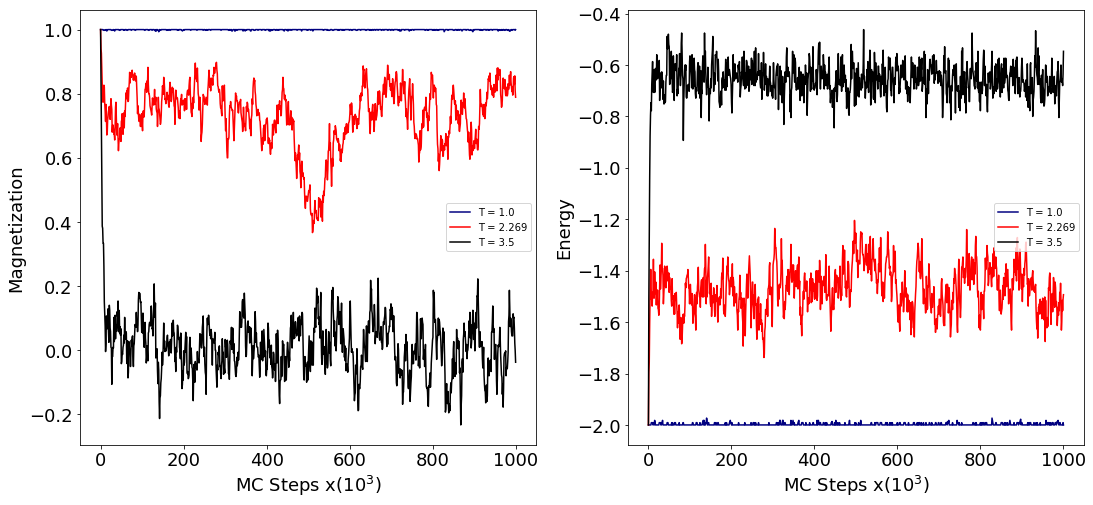

In [188]:
T_c = 2/np.log(1 + np.sqrt(2))  #known value from Onsager
time_f= int(1e3)   
realiz=1
l=30
temperatures = [1.0, 2.269, 3.5]
mc_steps=np.linspace(0,time_f,time_f)
col_map = np.array(["navy", "red", "black"])
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
color_count=0

for T in temperatures:
    magnetizations=np.zeros(time_f)
    energies=np.zeros(time_f)
        
    for r in range(0,realiz):
        s = np.ones((l,l))

        for t in range(0,time_f):
            m = magnetization(s)
            magnetizations[t] = magnetizations[t]+m/realiz
            energies[t] = energies[t]+energy(s)/realiz
            s = mc_step(s, T)
              
    ax1.plot(mc_steps, magnetizations/(l**2), label = 'T = {0}'.format(T), c =col_map[color_count] )
    ax1.legend(loc = 'best')
    ax2.plot(mc_steps, energies/(l**2), label = 'T = {0}'.format(T),c =col_map[color_count])
    ax2.legend(loc = 'center right')
    ax1.set_xlabel("MC Steps x($10^3)$", fontsize = 18)
    ax2.set_xlabel("MC Steps x($10^3)$", fontsize = 18)
    ax1.set_ylabel("Magnetization", fontsize = 18)
    ax2.set_ylabel("Energy", fontsize = 18)
    ax1.tick_params(axis="x",labelsize=18)
    ax2.tick_params(axis="x",labelsize=18)
    ax1.tick_params(axis="y",labelsize=18)
    ax2.tick_params(axis="y",labelsize=18)
    color_count+=1
plt.show()

Another test we can run in order to see if the simulated system behaves as exected is to simulate a ground state (all spins up) and to see if it reach the same equilibrium state of a random one, setting the temperature to $T=3.5$ for exemple.

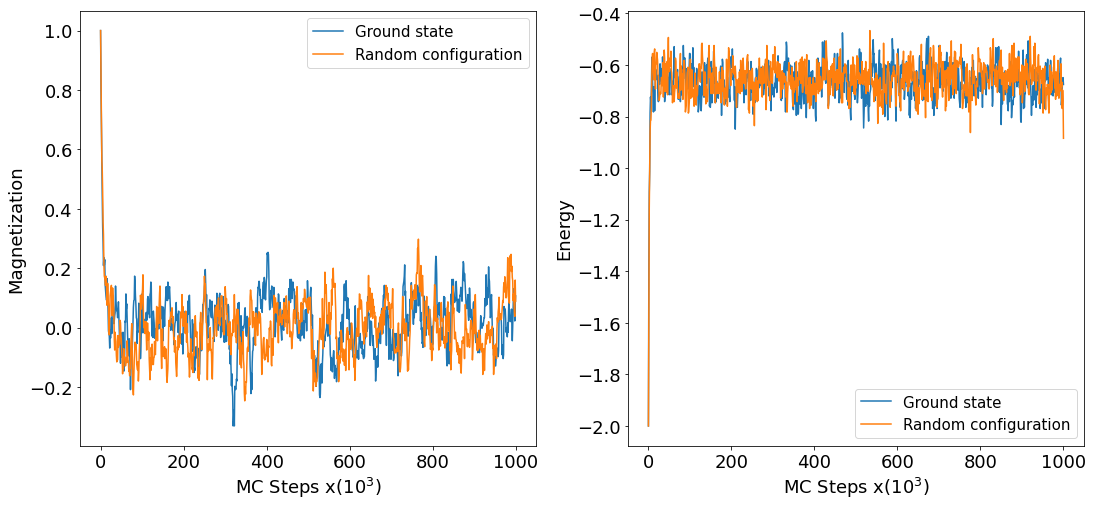

In [201]:
T_c = 2/np.log(1 + np.sqrt(2))  #known value from Onsager
time_f= int(1e3)   
realiz=1
l=30
T=3.5
order = [0,1]
labels = ["Ground state","Random configuration"]
mc_steps=np.linspace(0,time_f,time_f)
col_map = np.array(["navy", "red", "black"])
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
count=0

for r in order:
    magnetizations=np.zeros(time_f)
    energies=np.zeros(time_f)
        
    for r in range(0,realiz):
        if r==0: s = np.ones((l,l))
        if r==1: s= init_lattice(l)
            
        for t in range(0,time_f):
            m = magnetization(s)
            magnetizations[t] = magnetizations[t]+m/realiz
            energies[t] = energies[t]+energy(s)/realiz
            s = mc_step(s, T)
              
    ax1.plot(mc_steps, magnetizations/(l**2), label = str(labels[count]))
    ax2.plot(mc_steps, energies/(l**2), label = str(labels[count]))
    ax1.set_xlabel("MC Steps x($10^3)$", fontsize = 18)
    ax2.set_xlabel("MC Steps x($10^3)$", fontsize = 18)
    ax1.set_ylabel("Magnetization", fontsize = 18)
    ax2.set_ylabel("Energy", fontsize = 18)
    ax1.tick_params(axis="x",labelsize=18)
    ax2.tick_params(axis="x",labelsize=18)
    ax1.tick_params(axis="y",labelsize=18)
    ax2.tick_params(axis="y",labelsize=18)
    ax1.legend(fontsize = 15, loc=0)
    ax2.legend(fontsize = 15, loc=0)
    count+=1
plt.show()

# **PLOT**

In [102]:
#import all the data of simulations
L_val=[8,16,50,70,80,100,128]
data = np.loadtxt('Chi_tot.txt')
Chi_tot = np.array(data)
data = np.loadtxt('specific_heat_tot.txt')
C_tot = np.array(data)
data = np.loadtxt('magnetization_tot.txt')
M_tot = np.array(data)
data = np.loadtxt('energy_tot.txt')
E_tot = np.array(data)

In the following figure, magnetization per site $M$, energy per site $E$, magnetic susceptibility per site $χ$, and specific heat per site $C$ as functions of the temperature T are presented. This plots were constructed by performing
$10.000$ Monte Carlo steps per lattice size L. All simulations were performed considering $k_B = 1$ and $J = 1$.

Notice that because magnetization, energy, specific heat and magnetic susceptibility are extensive variables, intensive ones were constructed by dividing them by the number of sites in the lattice $N = L^2$ .

In [116]:
def plot_values (E,M,C,Chi,L_val):
    titles = ['Energy','Magnetisation','Specific Heat','Susceptibility']
    #labels = ['e', 'm', 'c', 'chi']
    physical_quantities = [E,np.abs(M),C,Chi]
    plt.figure(figsize = (16,10))
    for i in range(len(physical_quantities)):
        ax = plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        #ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in [0,1,2,3,4,5]:
            ax.plot(Te, physical_quantities[i][j] / L_val[j]**2, '.',markersize=9, label='N='+str(L_val[j]), alpha=0.7)
            
            ax.legend()
    plt.savefig('im.png')       
    plt.subplots_adjust(hspace=0.8)

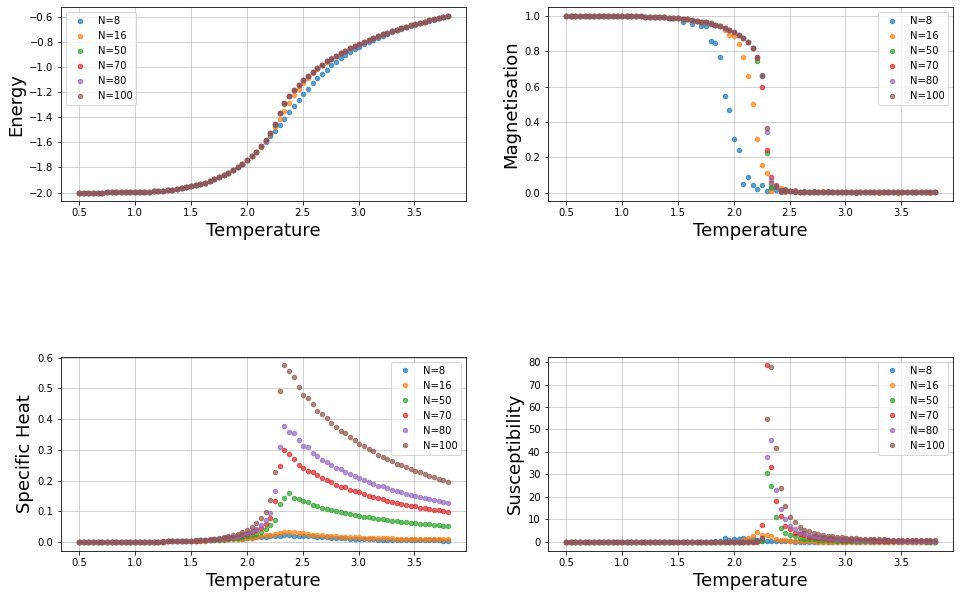

In [117]:
plot_values(E_tot,M_tot,C_tot,Chi_tot,L_val)

# **Critical exponent estimation**

## Exponent $\gamma$

In the termodinamic limit $N\rightarrow \infty$, we know that $\chi \sim |T-T_c|^{-\gamma}$. We try to estimate $\gamma$ as N increases. The expected value for 2D Ising is $\gamma=7/4 \sim 1.75$

48
53
50
44
45
44
44


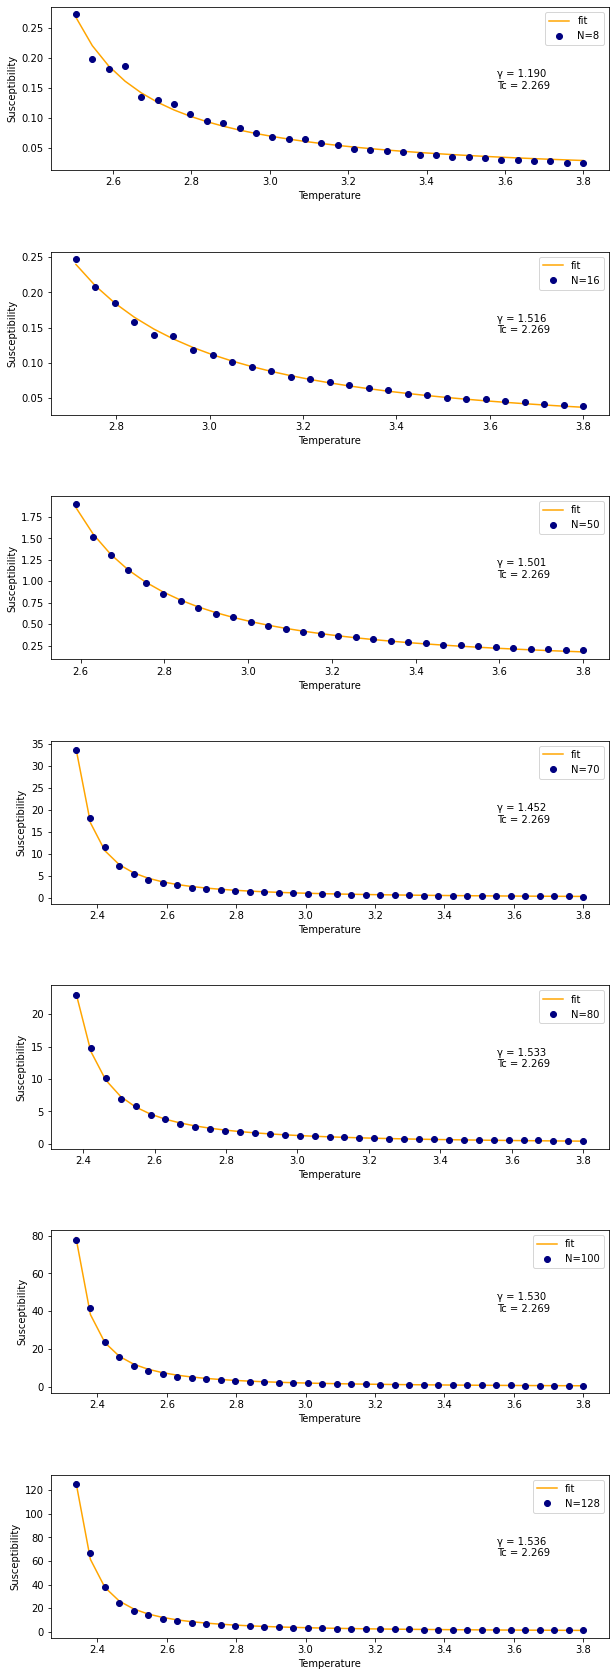

In [67]:
from scipy import optimize

T_c = 2.269     #known value from Onsager
tt = [10, 12, 7,1,1,0,1]

def powerlaw(T, k=1, gamma=1.75):
    return k*(np.abs(T-T_c))**(-gamma)

ks, gammas, = np.zeros((len(L_val))),np.zeros((len(L_val)))
fig, axs = plt.subplots(nrows=len(L_val), ncols=1, figsize=(10, 30))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()

for i in range(len(L_val)):
    Tmax = np.argmax(Chi_tot[i]) +tt[i]#we start from the peak of chi, we study the decreasing exponential
    params, params_covariance = optimize.curve_fit(powerlaw, Te[Tmax:], Chi_tot[i][Tmax:]/L_val[i]**2, maxfev=int(1e9))
    ks[i] = params[0]
    gammas[i] = params[1]
    #Tcs[i] = params[2]
    print(Tmax)
    axs[i].plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[i], gammas[i]),'orange', label='fit')
    axs[i].plot(Te[Tmax:], Chi_tot[i][Tmax:]/L_val[i]**2, 'o',color="navy", label='N={}'.format(L_val[i]))
    axs[i].text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(gammas[i]),'%.3f'%T_c), transform=axs[i].transAxes)
    axs[i].set_xlabel('Temperature')
    axs[i].set_ylabel('Susceptibility')
    axs[i].legend()

fig.savefig('full_figure_gamma.png')

# **CRITICAL EXPONENT BETA**

In the termodinamic limit $N\rightarrow \infty$, we know that $M \sim |T-T_c|^{-\beta}$. We try to estimate $\beta$ as N increases. The expected value for 2D Ising model is $\beta=1/8 \sim 0.125$.
It is worth to notice the importance of considering large systems in order to obtain reliable results of the thermodynamic quantities because Onsager’s solution is in the thermodynamic limit while numerical simulations are finite. We run a simulation for $L=[70, 100]$, $100$ realizations and $80$ temperatures around $T_c$.

In [70]:
L_val=[100]
nl = int(len(L_val))
time_f = int(1e4)    
realiz = 100    
nt = 80
E_b,M_b,C_b,Chi_b = np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt))
Te = np.linspace(0.9*T_c,1.1*T_c,nt)
for il,L in enumerate(L_val):
    print('Simulating N={}'.format(L))
    for it,T in enumerate(Te):
        E,M,C,Chi = old_Ising(L,T,time_f,realiz)
        E_b[il,it] = E
        M_b[il,it] = M
        C_b[il,it] = C
        Chi_b[il,it] = Chi

Simulating N=100


T_{c} = 2.273 (95% confidence interval = 2.272 2.273])

beta = 0.121 (95% confidence interval = [0.119 0.123])


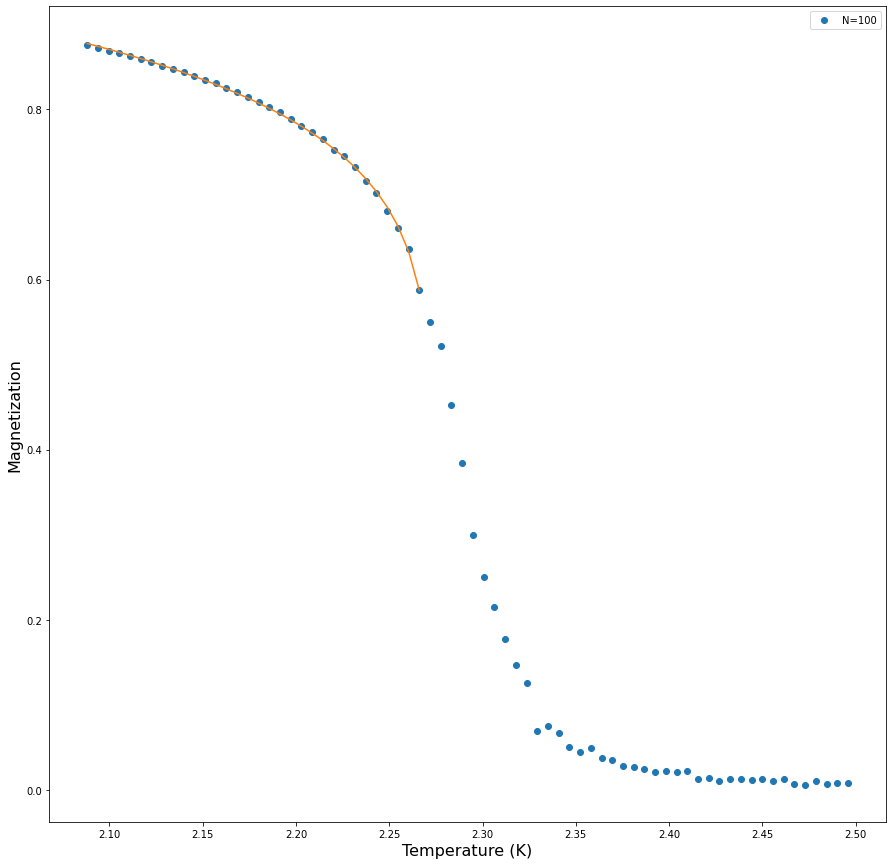

In [92]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
from pycse import nlinfit # ---> pip install pycse

T_c = 2/np.log(1 + np.sqrt(2))  #known value from Onsager

for i in range(len(L_val)):

    # Let us fit the first 45 values on the left of Onsager's Tc
    Ts2fit = Te[8:40]
    M2fit = M_b[i][8:40]/100**2

    # Function to fit to
    def M_fit(Ts, Tcinf, beta, a):
        M = a * np.abs((-Ts + Tcinf) / Tcinf) ** beta
        return M

    # Initial guess
    guess = [2.3, 0.11, 1]

    pars, pint, SE = nlinfit(M_fit, Ts2fit, M2fit, guess, alpha=0.05)
    Tcinf, beta, a = pint
    Tcinf=pars[0]
    beta=pars[1]
    a=pars[2]

    print ('T_{{c}} = {0:1.3f} (95% confidence interval = {1:1.3f} {2:1.3f}])\n'.format(pars[0], pint[0][0], pint[0][1]))
    print ('beta = {0:1.3f} (95% confidence interval = [{1:1.3f} {2:1.3f}])'.format(pars[1], pint[1][0], pint[1][1]))

    # Plotting
    Tfit = np.linspace(Ts2fit.min(), T_c)
    plt.rcParams["figure.figsize"] = (15,15)
    plt.plot(Te[8:], M_b[i][8:]/100**2, 'o', label='N=' + str(L_val[i]))
    Ts2fit = Te[8:40]
    plt.plot(Ts2fit, M_fit(Ts2fit, Tcinf, beta, a))
    plt.xlabel('Temperature (K)', fontsize=16)
    plt.ylabel('Magnetization', fontsize=16)
    plt.legend()
    plt.savefig('beta_extimation_nonlinearfit.png')
    plt.show()

In [95]:
print(M_b/100**2)

[[0.896 0.894 0.891 0.889 0.886 0.884 0.881 0.878 0.875 0.872 0.869 0.866
  0.863 0.859 0.856 0.852 0.848 0.844 0.84  0.835 0.831 0.825 0.82  0.815
  0.809 0.803 0.797 0.789 0.781 0.773 0.765 0.753 0.745 0.732 0.716 0.701
  0.68  0.661 0.636 0.588 0.55  0.521 0.453 0.384 0.299 0.251 0.215 0.178
  0.147 0.126 0.069 0.075 0.067 0.05  0.044 0.049 0.037 0.035 0.028 0.027
  0.024 0.021 0.022 0.021 0.023 0.013 0.014 0.01  0.013 0.013 0.012 0.013
  0.01  0.012 0.008 0.006 0.011 0.007 0.008 0.009]]


Results for beta:
    * N=70
    * Tc = 2.272 (95% confidence interval = 2.271 2.273])
    * beta = 0.125 (95% confidence interval = [0.119 0.130])
    
    *N=100
    *Tc = 2.273 (95% confidence interval = 2.272 2.273])
    *beta = 0.121 (95% confidence interval = [0.119 0.123])


save old data from simulations up to 80 

In [20]:
np.savetxt('energy.txt', E_old)
np.savetxt('magnetization.txt', M_old)
np.savetxt('specific_heat.txt', C_old)
np.savetxt('Chi.txt', Chi_old)